In [1]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import ast

In [16]:
results = ap.DataDict.load(exp_name='BoidsModel', exp_id=3)

Loading from directory ap_output/BoidsModel_3/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [17]:
results.reporters

,seed,initial_aligment,initial_cohesion,initial_separation_min,initial_separation_max,initial_separation_avg,initial_border_distance_min,initial_border_distance_max,initial_border_distance_avg,cohesion_strength,seperation_strength,alignment_strength,border_strength,final_alignment,final_cohesion,final_separation_std,cohesion_separation_ratio,final_border_distance_median,flock_density
sample_id,,,,,,,,,,,,,,,,,,,
0,38151356693563145563839572916692094389,0.499966,19.200069,0.319792,66.152410,26.362112,0.066371,24.737498,12.475071,0.005,0.05,0.1,0.1,0.492022,19.250940,12.099731,1.591022,12.705658,0.082646
1,50643080413437459039891721527947746584,0.499943,19.005887,0.096202,67.875181,26.119247,0.062641,24.767882,12.538531,0.005,0.05,0.1,0.3,0.428570,11.092369,7.807814,1.420675,18.464348,0.128077
2,312127559848672518524847992096161179002,0.495077,19.661868,0.150070,67.075642,26.781665,0.005508,24.964238,12.088859,0.005,0.05,0.1,0.5,0.422417,10.738726,8.046553,1.334575,15.877926,0.124277
3,172404514684537372690002572384054852500,0.499261,19.144436,0.090780,65.972330,26.247291,0.134393,24.770214,12.302738,0.005,0.05,0.1,0.7,0.484247,9.411016,6.572552,1.431866,19.632345,0.152148
4,147794254018547926221397844692364101129,0.499999,19.640490,0.053723,66.475022,26.571026,0.018470,24.986188,12.327421,0.005,0.05,0.3,0.1,0.480275,9.516387,6.528677,1.457629,14.578722,0.153170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,52412718949631819747544111393437644825,0.499991,18.668077,0.138637,66.916185,25.792290,0.003769,24.976840,12.872562,0.100,0.50,0.5,0.7,0.498644,12.257703,7.888525,1.553865,17.253337,0.126766
252,140228926601703206815859071822633611095,0.499496,19.712955,0.169949,67.746495,26.998304,0.078497,24.978141,12.070995,0.100,0.50,0.7,0.1,0.499998,13.252440,8.559090,1.548347,16.760117,0.116835
253,338707187910185731808512840315219375846,0.497117,18.118075,0.212702,65.237032,24.975210,0.149645,24.927328,13.228536,0.100,0.50,0.7,0.3,0.499786,12.681342,8.171251,1.551946,17.061528,0.122380


In [21]:
def process_data(X, Y, normalize=True):
    # Split the data into training+validation set and test set
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Split the training+validation set into separate training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

    # Convert pandas dataframes to numpy arrays (if not already in numpy format)
    X_train_np, Y_train_np = X_train.values, Y_train.values
    X_val_np, Y_val_np = X_val.values, Y_val.values
    X_test_np, Y_test_np = X_test.values, Y_test.values

    if normalize:
        # Initialize scalers for X and Y
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        # Fit and transform the training data
        X_train, Y_train= scaler_X.fit_transform(X_train_np), scaler_Y.fit_transform(Y_train_np)

        # Transform the validation and test data
        X_val, Y_val = scaler_X.transform(X_val_np), scaler_Y.transform(Y_val_np)
        X_test, Y_test = scaler_X.transform(X_test_np), scaler_Y.transform(Y_test_np)

    
    # Convert the numpy arrays back to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_val = torch.tensor(Y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [22]:
output_parameters = ['final_alignment', 'cohesion_separation_ratio', 'flock_density']
knobs = ['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']

Y = results.reporters[output_parameters]
X =  results.reporters[knobs]

X_train, Y_train, X_val, Y_val, X_test, Y_test = process_data(X, Y, normalize=True)

/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

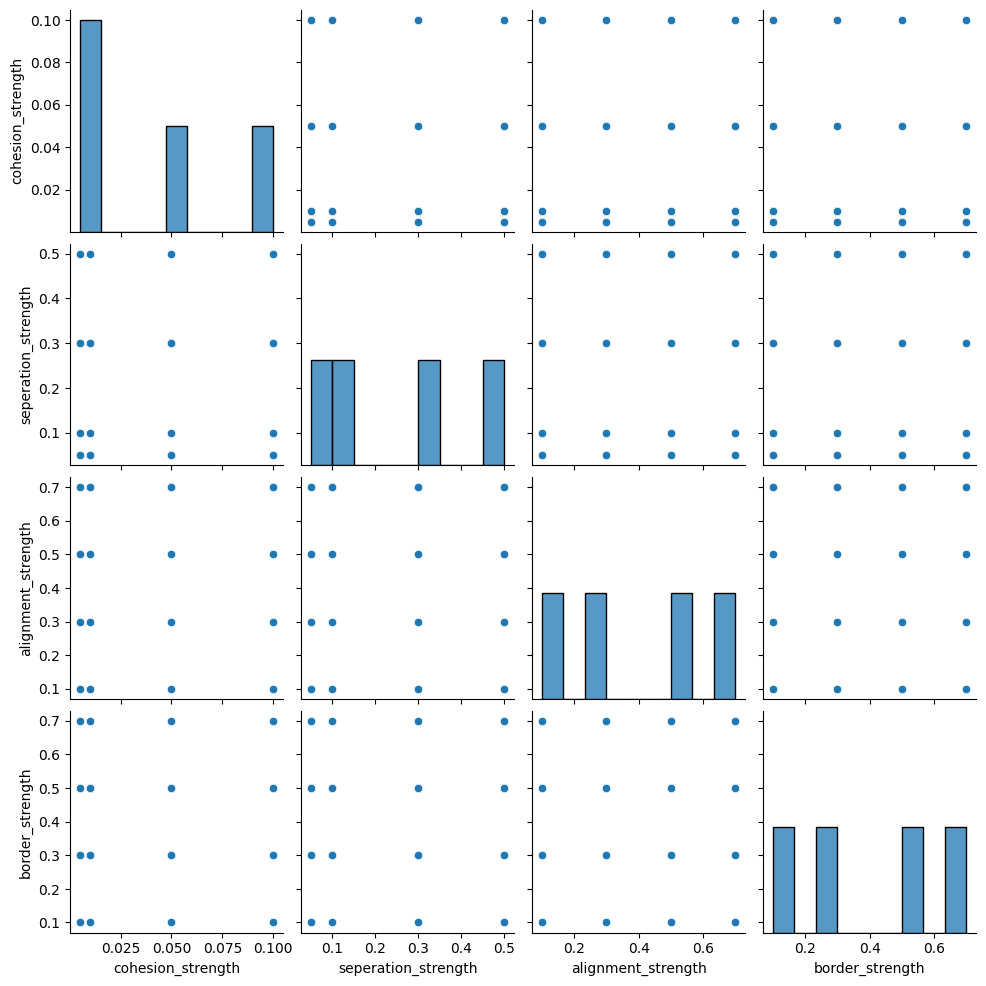

In [23]:
sns.pairplot(X)

In [7]:
correlation_matrix = X.corr()
print(correlation_matrix)

                     cohesion_strength  seperation_strength  \
cohesion_strength         1.000000e+00        -2.407491e-16   
seperation_strength      -2.407491e-16         1.000000e+00   
alignment_strength        3.856209e-16         1.002786e-16   
border_strength          -3.167600e-16        -2.504696e-16   

                     alignment_strength  border_strength  
cohesion_strength          3.856209e-16    -3.167600e-16  
seperation_strength        1.002786e-16    -2.504696e-16  
alignment_strength         1.000000e+00    -3.180326e-17  
border_strength           -3.180326e-17     1.000000e+00  


In [24]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, X, Y):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [25]:
model = Net(X_train, Y_train)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(1000):  # Number of epochs
    optimizer.zero_grad()   # Zero the gradient buffers
    output = model(X_train)         # Pass the batch through the network
    loss = criterion(output, Y_train)  # Compute the loss
    loss.backward()         # Backpropagation
    optimizer.step()        # Update weights

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model with test data (if available)

Epoch 1, Loss: 1.0270135402679443
Epoch 101, Loss: 0.1221168264746666
Epoch 201, Loss: 0.05339355766773224
Epoch 301, Loss: 0.032177362591028214
Epoch 401, Loss: 0.024071961641311646
Epoch 501, Loss: 0.006857609376311302
Epoch 601, Loss: 0.007262438535690308
Epoch 701, Loss: 0.006480999756604433
Epoch 801, Loss: 0.0035484677646309137
Epoch 901, Loss: 0.00220084423199296


In [26]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Do not calculate gradients to save memory
    # Calculate the predictions for the test set
    Y_pred = model(X_test)

    # Calculate the loss for the test set
    test_loss = criterion(Y_pred, Y_test)

print(f'Test loss: {test_loss.item()}')

Test loss: 1.1865671873092651


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predictions for the test set
Y_pred = model(X_test)

# Convert the predictions and true values to NumPy arrays
Y_pred_np = Y_pred.detach().numpy()
Y_test_np = Y_test.numpy()

# Calculate the metrics
mae = mean_absolute_error(Y_test_np, Y_pred_np)
mse = mean_squared_error(Y_test_np, Y_pred_np)
r2 = r2_score(Y_test_np, Y_pred_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 0.5586182475090027, MSE: 1.1865671873092651, R^2: -0.23351126808360442


/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

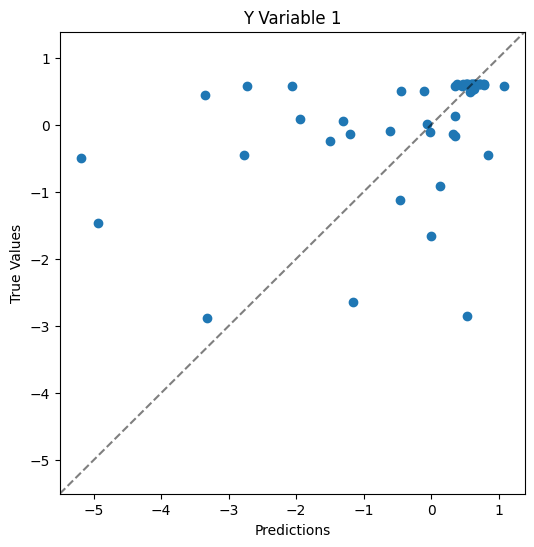

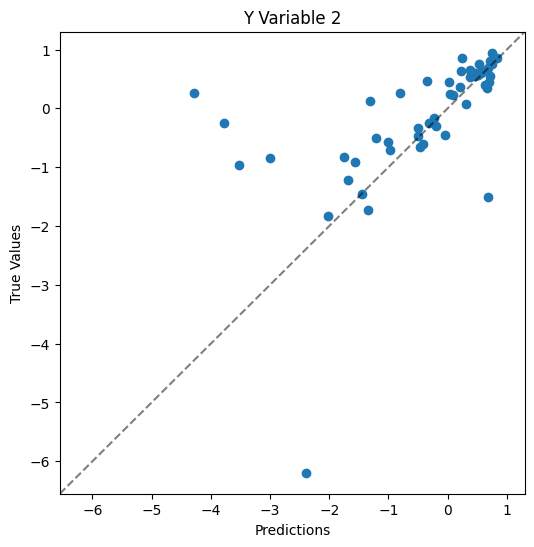

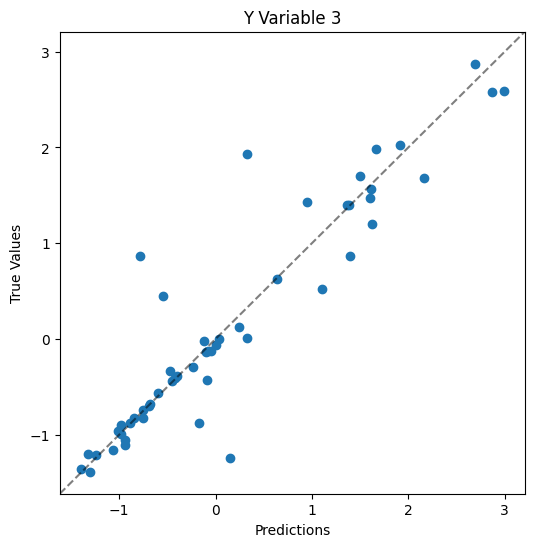

In [32]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(Y_pred.size(1)):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred_np[:, i], Y_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()